### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 12th at 11.59pm CT
---

## Problem 1

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

## Problem 2

The first few steps of this problem are the same as the previous problem.


1. Read in the same galaxy color data used above. Slice the data array to only take every other 10th row. From this reduced data volume, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. 


2. We're going to make classification pretty tough for our deep neural network. Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class. Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$. The plot should include appropriate axis labels and a legend.


3. Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing. Set the `random_state` in your train-test split to be `42` for reproducibility (and easy comparison with my solutions).


4. Scale your training and testing data to prepare it for the DNN. 


5. Train scikit-learn's multi-layer perceptron classifier with ReLU activation, stochastic gradient descent, two hidden layers of respective sizes of $5$ and $2$, and using `max_iter=1000`, and `random_state=42`. As with classifiers in last week's homework, plot an ROC curve that shows the network's performance on the scaled testing data. 


6. Now let's optimize the hyperparameters of your network. You will use `GridSearchCV` with the following hyperparameters for the network:

```
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
```

Remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.


7. Fit a new DNN using the best hyperparameters obtained in (6), and make a plot that has ROC curves for this new network and your original network. Let the x and y axes have the full limit range of 0 to 1. Voila!

## Problem 1 Solution

In [37]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from matplotlib.lines import Line2D

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [38]:
#1 Load Data
data = np.load('./hw_data/hw8_data_1.npy')
u,g,r,i,z,red,Class = [data['u'],data['g'],data['r'],data['i'],data['z'], data['redshift'],data['specClass']]
Colors = Class == 'QSO'

#Array of the colors
u_g = u-g
g_r = g-r
r_i = r-i
i_z = i-z

print(len(Class[Colors]), 'Quasars')
print(len(Class)-len(Class[Colors]), 'Galaxies')

7192 Quasars
42808 Galaxies


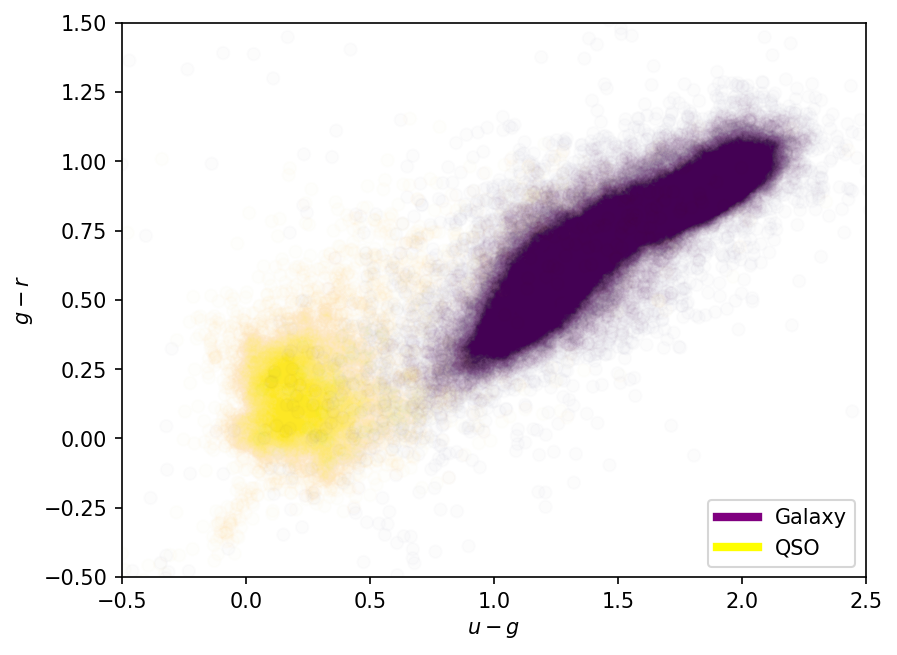

In [4]:
#2 Plotting the Data
marks = [Line2D([0], [0], color='purple', lw=4), Line2D([0], [0], color='yellow', lw=4)]
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
plt.xlabel('$u-g$')
plt.ylabel('$g-r$')
scatter = plt.scatter(u_g,g_r, c = Colors, alpha = 0.01)
plt.legend(marks, ['Galaxy','QSO'])


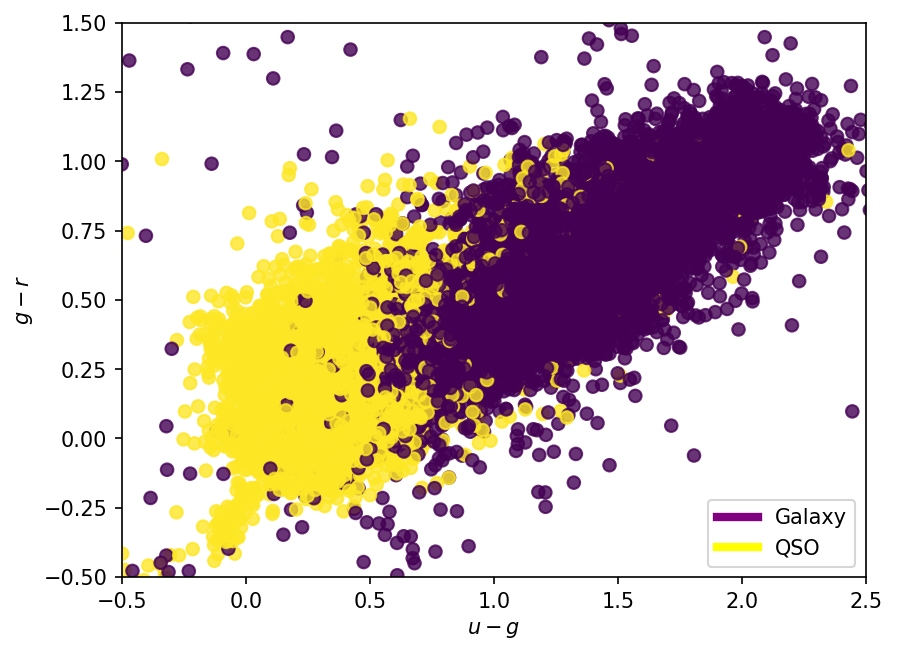

In [39]:
#If you're interested in complete raw data, this is what it looks like, I thought that decreasing the alpha makes the points look more distinct
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
marks = [Line2D([0], [0], color='purple', lw=4), Line2D([0], [0], color='yellow', lw=4)]
plt.xlabel('$u-g$')
plt.ylabel('$g-r$')
scatter = plt.scatter(u_g,g_r, c = Colors, alpha = 0.8)
handles, labels = scatter.legend_elements()
plt.legend(marks, ['Galaxy','QSO'])

In [40]:
#3 Setting up data array and training
X=np.array([u_g,g_r,r_i,i_z,red]).T
X_80, X_20, C_80, C_20 = train_test_split(X,Class, test_size=0.2, random_state=3)
Bests = [] #Setup for later

Text(0, 0.5, 'True Positive Rate')

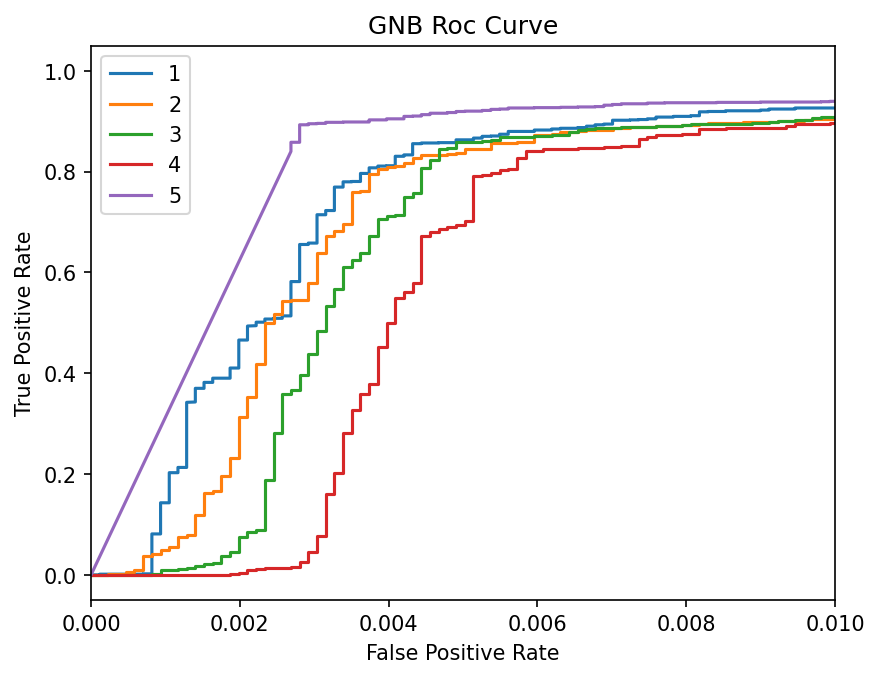

In [46]:
#4
plt.xlim(0,0.01)
GNB_tpr = []
GNB_fpr = []
Area_GNB = []
Color = np.arange(1,X.shape[1]+1)
y_prob = np.array([])
T = C_20 == 'QSO'
plt.title('GNB Roc Curve')
GNB = GaussianNB() 
for c in Color:
    GNB.fit(X_80[:, :c], C_80)
    C_prob = GNB.predict_proba(X_20[:, :c])[:,1]
    fp, tp ,thr = roc_curve(T,C_prob)
    plt.plot(fp,tp, label = c)
    Area_GNB.append(np.sum(np.diff(fp)*tp[:-1]))
    GNB_tpr.append(tp)
    GNB_fpr.append(fp)
Best_GNB= np.argmax(Area_GNB)
Bests.append(max(Area_GNB))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

It seems that redshift makes classification trivial

SRT: Right!

Text(0, 0.5, 'True Positive Rate')

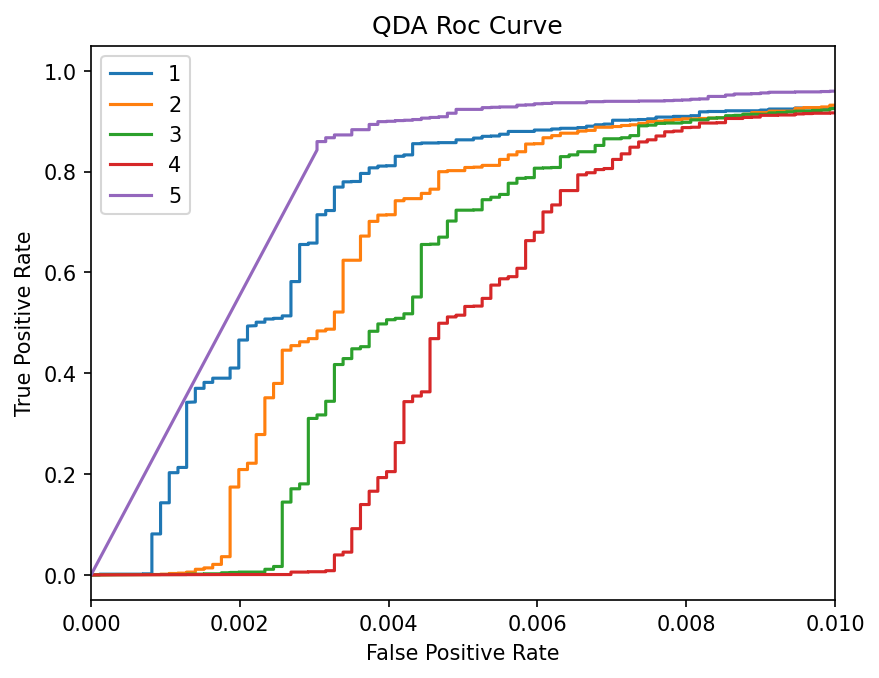

In [47]:
#5
plt.xlim(0,0.01)
QDA_tpr = []
QDA_fpr = []
Color = np.arange(1,X.shape[1]+1)
y_prob = np.array([])
Area_QDA = []
plt.title(' QDA Roc Curve')
qda = QDA()
for c in Color:
    qda.fit(X_80[:, :c], C_80)
    C_prob = qda.predict_proba(X_20[:, :c])[:,1]
    fp, tp ,thr = roc_curve(T,C_prob)
    Area_QDA.append(np.sum(np.diff(fp)*tp[:-1]))
    QDA_tpr.append(tp)
    QDA_fpr.append(fp)
    plt.plot(fp,tp, label = c)
Best_QDA= np.argmax(Area_QDA)
Bests.append(max(Area_QDA))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

The same is true for QDA, redshift the best

10 is the best, note this flucuates a bit, previously I got 7


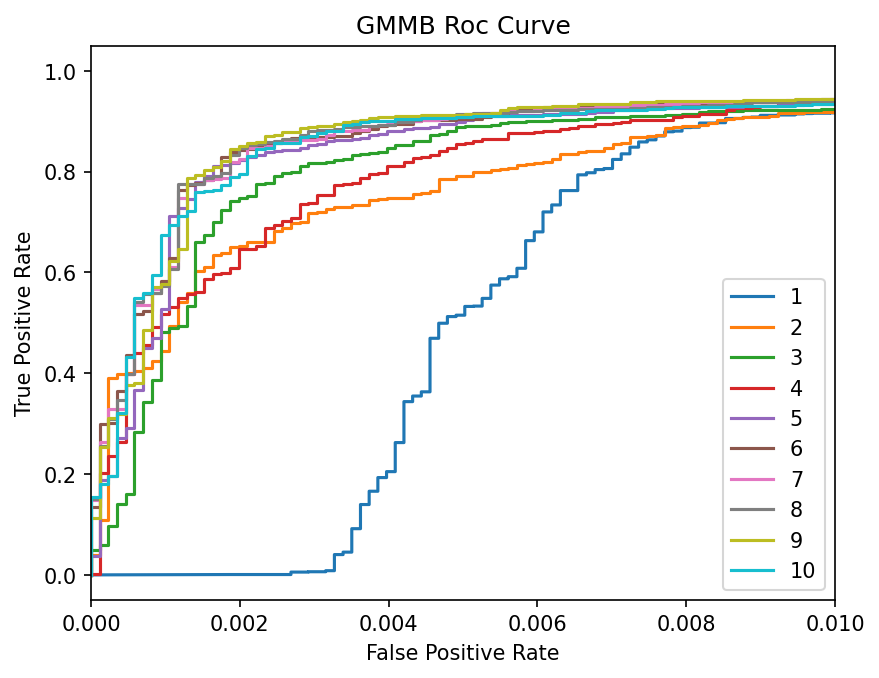

In [48]:
#6
Comp = np.arange(1,11)
plt.title('GMMB Roc Curve')
plt.xlim(0,0.01)
GMMB_tpr = []
GMMB_fpr = []
Area_GMMB = []
for c in Comp:
    gmmb = GMMBayes(c) 
    gmmb.fit(X_80[:,:4],C_80)
    C1_prob = gmmb.predict_proba(X_20[:,:4])[:,1]
    fp, tp, thr = roc_curve(T,C1_prob)
    Area_GMMB.append(np.sum(np.diff(fp)*tp[:-1]))
    GMMB_tpr.append(tp)
    GMMB_fpr.append(fp)
    plt.plot(fp,tp, label = c)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
Best_GMMB=np.argmax(Area_GMMB)
Bests.append(max(Area_GMMB))
print(Comp[Best_GMMB], 'is the best, note this flucuates a bit, previously I got 7')

105.0 is the best


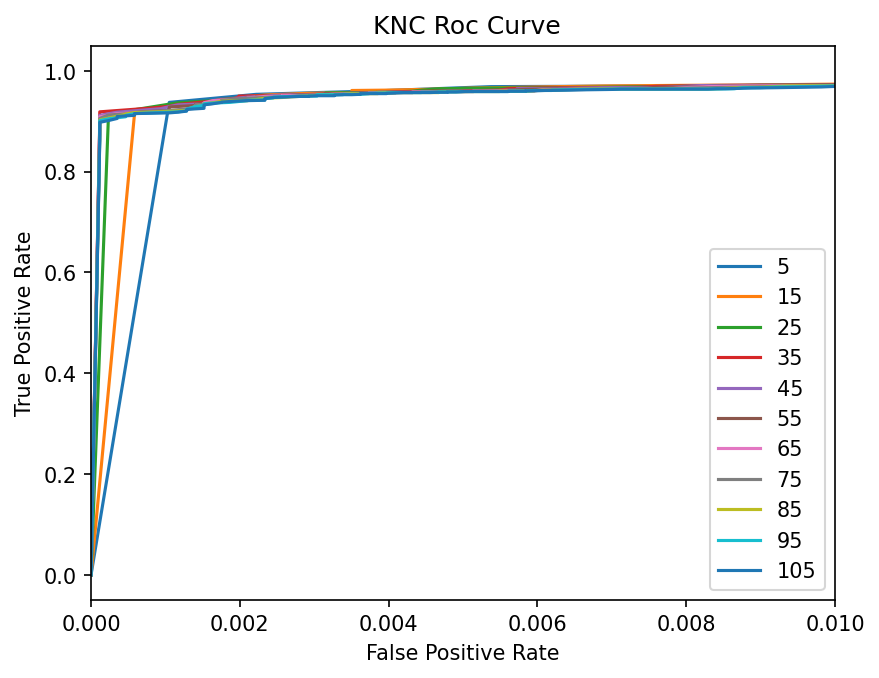

In [68]:
#7
Comp2 = np.linspace(5,105,11)
plt.xlim(0,0.01)
KNC_tpr = []
KNC_fpr = []
Area_KNC = []
plt.title(' KNC Roc Curve')
for c in Comp2:
    knc = KNeighborsClassifier(int(c)) # use 5 nearest neighbors
    knc.fit(X_80[:,:5],C_80)
    C1_prob = knc.predict_proba(X_20[:,:5])[:,1]
    fp, tp, thr = roc_curve(T,C1_prob)
    Area_KNC.append(np.sum(np.diff(fp)*tp[:-1]))
    KNC_tpr.append(tp)
    KNC_fpr.append(fp)
    plt.plot(fp,tp, label = int(c))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
Best_KNC = np.argmax(Area_KNC)
Bests.append(max(Area_KNC))
print(Comp2[Best_KNC], 'is the best')

SRT: Looks like you included redshift in the training here, Noah. Should just be the 4 colors. -2 points

8 is the best


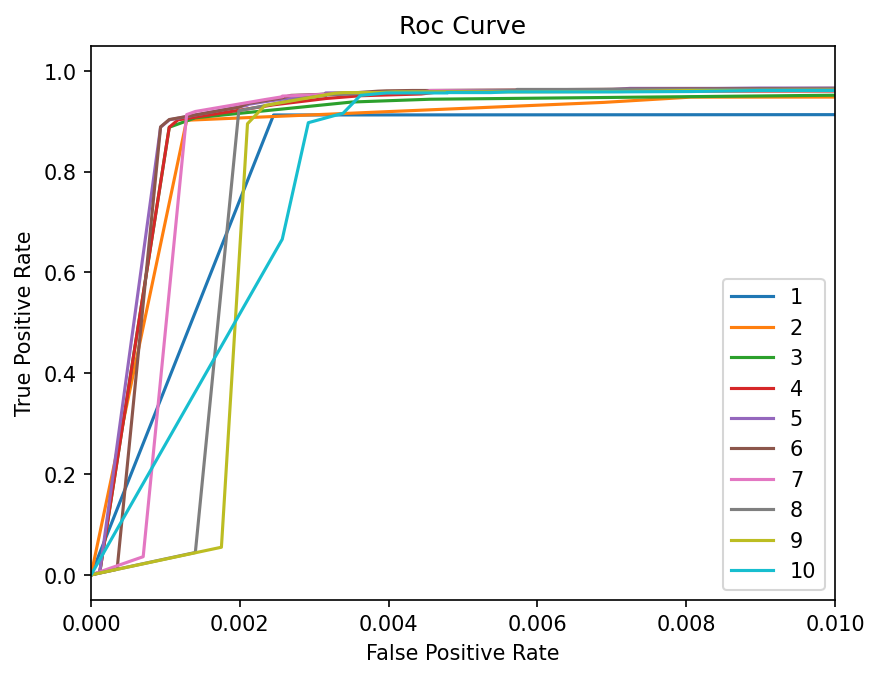

In [45]:
#8
TreeComb = np.arange(1,11)
plt.title(' Tree Roc Curve')
plt.xlim(0,0.01)
dtree_tpr = []
dtree_fpr = []
Area_TreeComb = []
for c in TreeComb:
    dtree = DecisionTreeClassifier(max_depth=c)
    dtree.fit(X_80[:,:5],C_80)
    C1_prob = dtree.predict_proba(X_20[:,:5])[:,1]
    fp, tp, thr = roc_curve(T,C1_prob)
    Area_TreeComb.append(np.sum(np.diff(fp)*tp[:-1]))
    dtree_tpr.append(tp)
    dtree_fpr.append(fp)
    plt.plot(fp,tp, label = int(c))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
Best_Tree = np.argmax(Area_TreeComb)
Bests.append(max(Area_TreeComb))
print(TreeComb[Best_Tree], 'is the best')

SRT: Same issue as above (including redshift) but no additional penalty.

Didn't specify to only use the best of GNB and QDA so including one that includes only the best and one with all of the GNB and QDA curve

KNeighborsClassifier(n_neighbors=105) note thus is a tossup between GHMMB and KNC


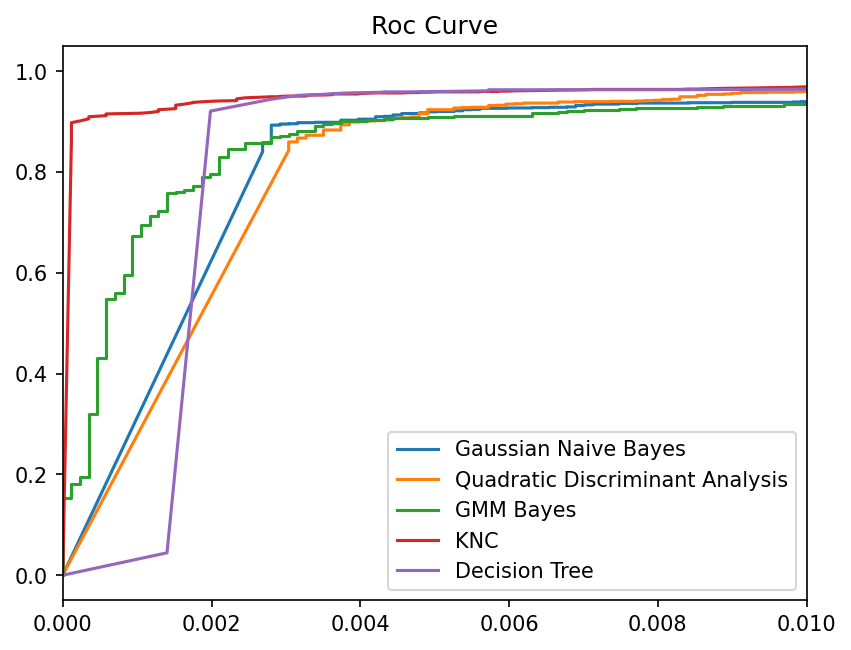

In [50]:
#9 With only the best GNB and QDA
plt.xlim(0,0.01)
plt.title('Roc Curve')
List = [GNB,qda,gmmb,knc,dtree]
plt.plot(GNB_fpr[Best_GNB],GNB_tpr[Best_GNB], label = 'Gaussian Naive Bayes')
plt.plot(QDA_fpr[Best_QDA],QDA_tpr[Best_QDA], label = 'Quadratic Discriminant Analysis')
plt.plot(GMMB_fpr[Best_GMMB],GMMB_tpr[Best_GMMB], label = 'GMM Bayes')
plt.plot(KNC_fpr[Best_KNC],KNC_tpr[Best_KNC], label = 'KNC')
plt.plot(dtree_fpr[Best_Tree],dtree_tpr[Best_Tree], label = 'Decision Tree')
plt.legend()
print(List[np.argmax(Bests)], 'note thus is a tossup between GHMMB and KNC')

KNeighborsClassifier(n_neighbors=105) note thus is a tossup between GHMMB and KNC


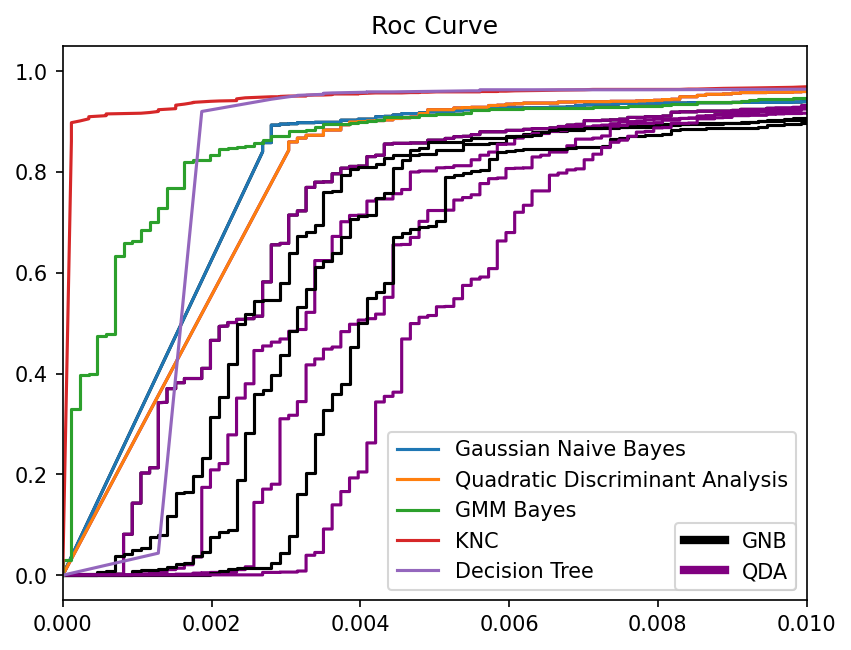

In [29]:
#9 Other
plt.title('Roc Curve')
plt.xlim(0,0.01)
for i in Color-1:
    plt.plot(GNB_fpr[i],GNB_tpr[i], c = 'k')
    plt.plot(QDA_fpr[i],QDA_tpr[i], c = 'purple')
marks2 = [Line2D([0], [0], color='black', lw=4), Line2D([0], [0], color='purple', lw=4)]
plt.plot(GNB_fpr[Best_GNB],GNB_tpr[Best_GNB], label = 'Gaussian Naive Bayes')
plt.plot(QDA_fpr[Best_QDA],QDA_tpr[Best_QDA], label = 'Quadratic Discriminant Analysis')
plt.plot(GMMB_fpr[Best_GMMB],GMMB_tpr[Best_GMMB], label = 'GMM Bayes')
plt.plot(KNC_fpr[Best_KNC],KNC_tpr[Best_KNC], label = 'KNC')
plt.plot(dtree_fpr[Best_Tree],dtree_tpr[Best_Tree], label = 'Decision Tree')
L1=plt.legend()
plt.legend(marks2,['GNB','QDA'])
plt.gca().add_artist(L1)
print(List[np.argmax(Bests)], 'note thus is a tossup between GHMMB and KNC')

Way more messy, but consistent with prior plot

Text(0.5, 1.0, 'Pred')

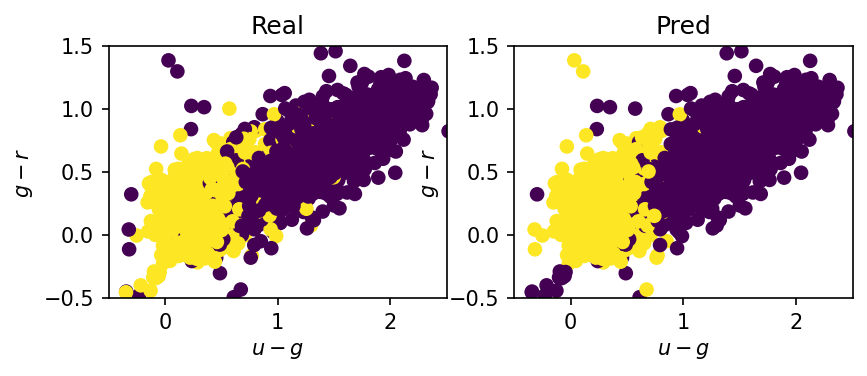

In [51]:
#10
Good = List[np.argmax(Bests)]
Good.fit(X_80[:,:4],C_80) #From observation its not gonna be QDA or GNB
C1_pred = gmmb.predict(X_20[:,:4])
C1_Check = C1_pred == 'QSO'
plt.subplot(2,2,1)
plt.scatter(X_20[:,0],X_20[:,1],c = T, alpha = 1) #High opacity to see mistakes
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
plt.xlabel('$u-g$')
plt.ylabel('$g-r$')
plt.title('Real')
plt.subplot(2,2,2)
plt.scatter(X_20[:,0],X_20[:,1],c = C1_Check, alpha = 1)
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
plt.xlabel('$u-g$')
plt.ylabel('$g-r$')
plt.title('Pred')

SRT: Shouldn't you have called `C1_pred = Good.predict(X_20[:,:4])` here? -1 point

## Problem 2 Solution

In [52]:
#1 & 3
X1 = X[::10,2:4] #First Alligning the arrays properly to test for new thing
Red = X[::10,4] 

#Note you can also do this
g_rnew = (g-r)[::10]
r_inew = (r-i)[::10]
#But the above method is more convenient, so I'll be using that; additionally it now partially solves a later questiom
ColorPrime = Class[::10] == 'QSO' #Taking every tenth data point

Not unsure the purpose of making your own Redshift array, since the only data in the matrix is the color, and it is not touched on later, I remembered what your result looked like so I decided to just do the one without redshit since it looked more similar 

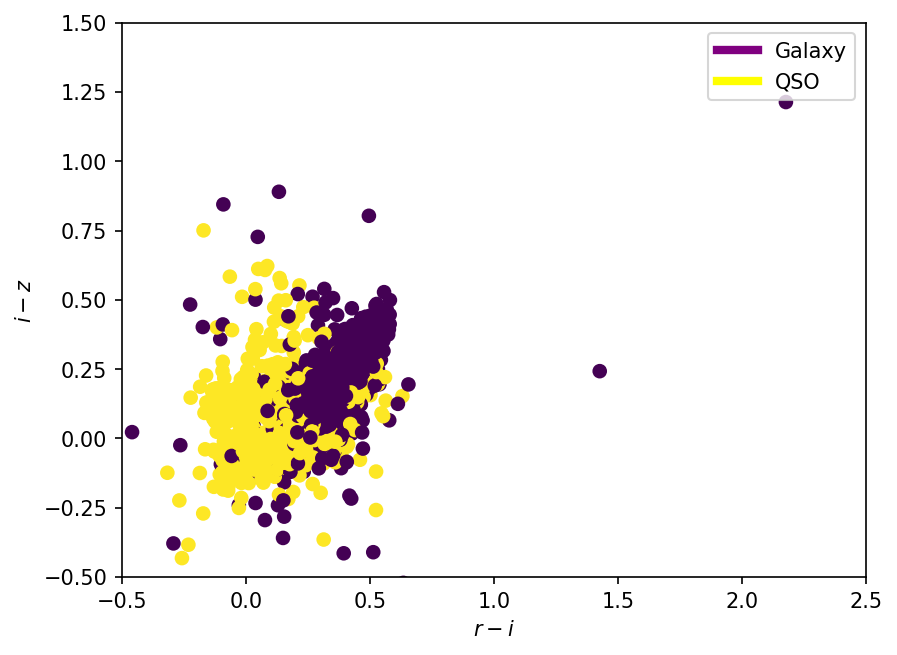

In [53]:
#2
plt.scatter(X1[:,0],X1[:,1], c = ColorPrime)
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
plt.xlabel('$r-i$')
plt.ylabel('$i-z$')
plt.legend(marks, ['Galaxy','QSO'])

In [54]:
#3 Cont.
X1_80, X1_20, T_80, T_20, Red_80,Red_20 = train_test_split(X1,ColorPrime*1, Red, test_size=0.2, random_state=42)

#4
Sc_80 = preprocessing.scale(X1_80)
Sc_20 = preprocessing.scale(X1_20)

#Alt
Sred_80 = preprocessing.scale(Red_80)
Sred_20 = preprocessing.scale(Red_20)


In [55]:
#5
MLP = MLPClassifier(activation='relu', solver='sgd', hidden_layer_sizes=(5,2), random_state=42, max_iter=1000)
MLP.fit(Sc_80,T_80)
T_pred = MLP.predict_proba(Sc_20)[:,1]
MLP_fp,MLP_tp, MLP_thr = roc_curve(T_20,T_pred)

Text(0, 0.5, 'True Positive Rate')

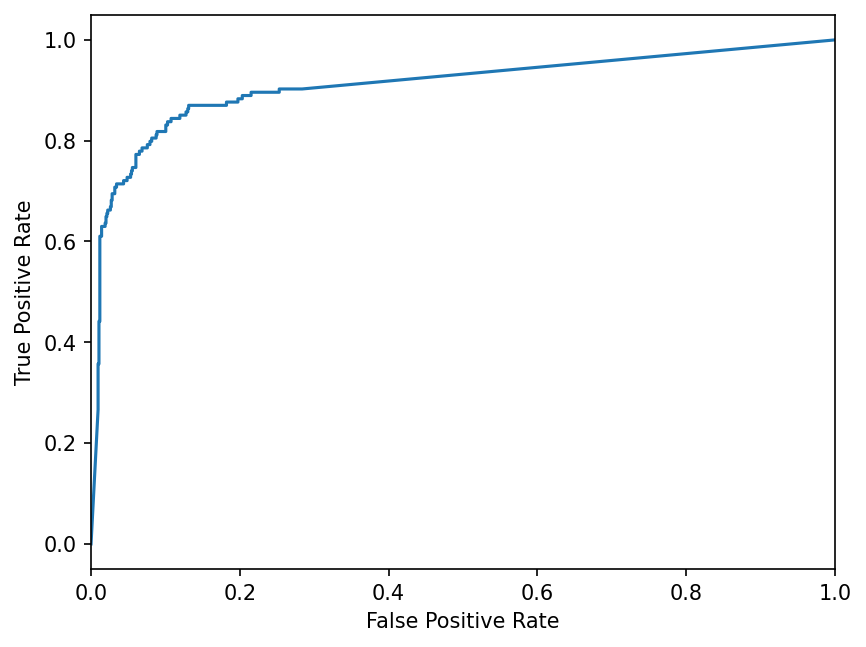

In [56]:
#5 Cont.
plt.xlim(0,1)
plt.plot(MLP_fp,MLP_tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [57]:
#6
MLPrime = GridSearchCV(MLPClassifier(), {'solver': ['lbfgs', 'sgd', 'adam'], 'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 'activation': ['relu', 'tanh'], 'random_state': [42], 'max_iter': [1000]}, n_jobs=-1)
MLPrime.fit(Sc_80,T_80)

/Users/noah/anaconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/noah/anaconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/noah/anaconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWa

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(2, 2), (5, 5), (5, 2),
                                                (5, 5, 5)],
                         'max_iter': [1000], 'random_state': [42],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [58]:
#6 Cont.
print(MLPrime.best_score_)
print(MLPrime.best_params_)

0.9365
{'activation': 'relu', 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 1000, 'random_state': 42, 'solver': 'lbfgs'}


In [59]:
#7
MLPost = MLPClassifier(activation = 'relu', hidden_layer_sizes = (5, 5, 5), max_iter = 1000, random_state = 42, solver = 'lbfgs')
MLPost.fit(Sc_80,T_80)
Post_Pred=MLPost.predict_proba(Sc_20)[:,1]
fppost,tppost,thrpost=roc_curve(T_20,Post_Pred)
Pred = np.round(Post_Pred)

Text(0, 0.5, 'True Positive Rate')

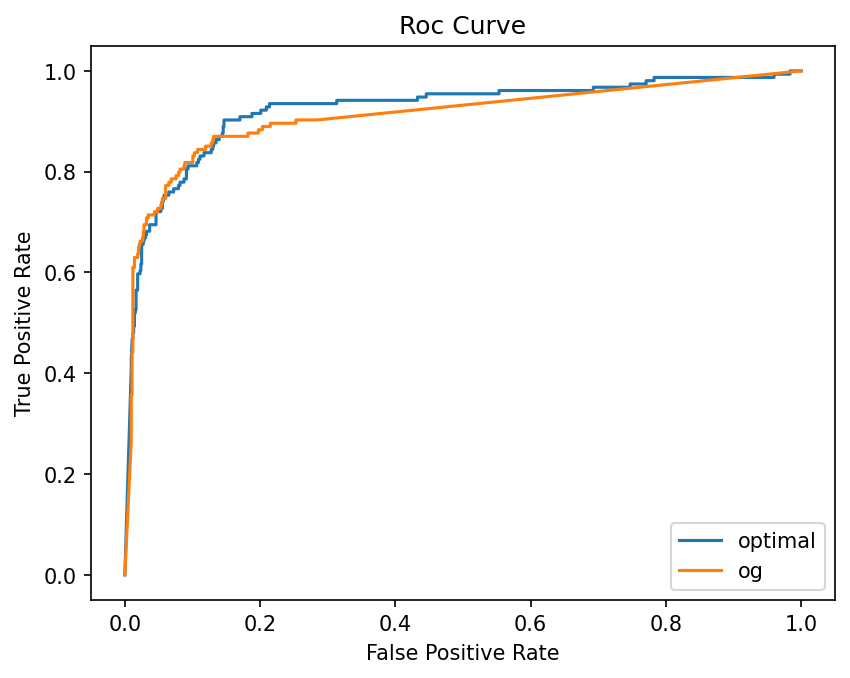

In [67]:
#7 Cont.
plt.title('Roc Curve')
plt.plot(fppost,tppost, label = 'optimal')
plt.plot(MLP_fp, MLP_tp, label = 'og')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


Text(0.5, 1.0, 'Pred')

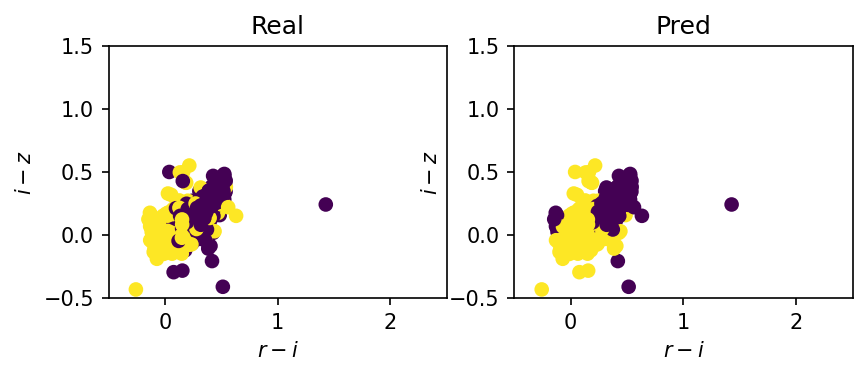

In [62]:
#Bonus
plt.subplot(2,2,1)
plt.scatter(X1_20[:,0],X1_20[:,1],c=T_20)
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
plt.xlabel('$r-i$')
plt.ylabel('$i-z$')
plt.title('Real')
plt.subplot(2,2,2)
plt.xlabel('$r-i$')
plt.ylabel('$i-z$')
plt.scatter(X1_20[:,0],X1_20[:,1],c=Pred)
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
plt.ylabel('$i-z$')
plt.title('Pred')

Pretty alright :D

SRT: Good! 

47/50

In [64]:
#4 Alt.
A=np.array([Sc_80[:,0],Sc_80[:,1],Sred_80]).T #Can't be read therwise
A2=np.array([Sc_20[:,0],Sc_20[:,1],Sred_20]).T

In [65]:
#5 Alt.
MLP = MLPClassifier(activation='relu', solver='sgd', hidden_layer_sizes=(5,2), random_state=42, max_iter=1000)
MLP.fit(A,T_80)
T_pred1 = MLP.predict_proba(A2)[:,1]
MLP_fpAlt,MLP_tpAlt, MLP_thrAlt = roc_curve(T_20,T_pred1)

Text(0, 0.5, 'True Positive Rate')

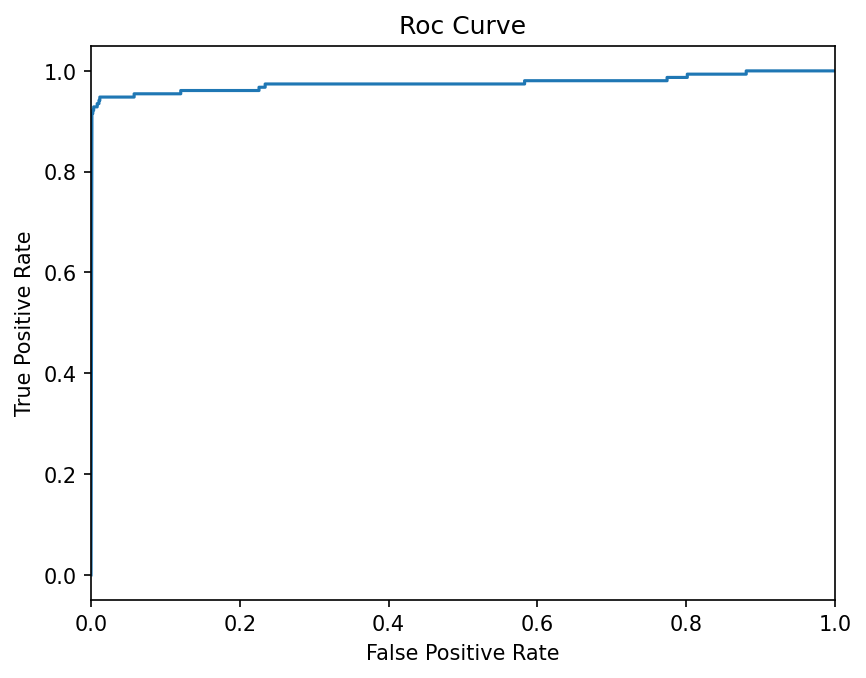

In [70]:
#5 Alt cont.
plt.title('Roc Curve')
plt.xlim(0,1)
plt.plot(MLP_fpAlt,MLP_tpAlt)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Doesn't look like yours